In [10]:
# import knihoven
import numpy as np # lineární algebra, počítání s vektory, maticemi
from matplotlib import pyplot as plt # vizualizace grafů, obrázků
import pandas as pd # v tomto programu pouze načtení dat, obecně nástroj pro manipulaci s daty
from random import randint

In [11]:
data_pd = pd.read_csv('train.csv') # načtení tréninkových dat pomocí pandas

In [12]:
data_pd.head() # zobrazení dat 

label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         0         0         0  
4         0         0         0         0  

[5 rows x 785 columns]

In [13]:
data = np.array(data_pd) # převod dat z pandas dataframe do numpy array (matice)
np.random.shuffle(data) # náhodně zamíchá data
m, n = np.shape(data) # m - počet řádků (záznamů), n - počet sloupců (pixely (vstupní data) + label (správná výstupní hodnota))

# rozdělení dat na trénovací a vývojová data, aby nedošlo k overfittingu

# development set (prvních 1000 řádků), 0 - 1000 bez 1000. záznamu
data_dev = data[0:1000].T # .T - transponováno - jeden záznam je nyní jeden sloupec, ne řádek (nutné pro správné násobení matic)
Y_dev = data_dev[0] # správné výstupní hodnoty Y (label), [řádky, sloupce], stejný zápis - [0,:] (nultý řádek a všechny sloupce)
X_dev = data_dev[1:n] # pixely
X_dev = X_dev / 255

# training set (zbývající řádky)
data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255

1. Training set - as the name suggests, this data set is used to train your classifier. It takes major chunk of your original data set.
2. Development set - used during evaluation of your classifier with different configurations or, variations in the feature representation. Its called development set, since you are using it while developing your classifier. It can be a bit biased, that's why we need third kind of data set.
3. Test set - Data set on which you finally check the accuracy of your classifier and get the unbiased results.

Zdroj: https://qr.ae/pr4y4j

**Generalizace** - generalizace, neboli zevšeobecňování, je jedním z hlavních cílů neuronové sítě. Jde o schopnost rozlišit a zařadit do správné kategorie i ty záznamy, se kterými se algoritmus ještě nikdy nesetkal.

**Overfitting** - opak generalizace. Overfitting znamená, že na trénovacích datech má algoritmus téměř 100% úspěšnost správného zařazení, ale není schopný rozpoznat nové záznamy. Děje se to proto, že algoritmus se trénovací data naučí v podstatě nazpaměť. Abychom overfittingu předešli, dělí se vstupní data na trénovací, ty na kterých se algoritmus trénuje, vývojová, na těch se algoritmus testuje v průběhu učení (kromě výkonu zde testujeme třeba i hyperparametry), a testovací, na těch se algoritmus testuje až po dokončení učebního procesu. Výsledky po testování testovacími daty by měly být nezkreslené a měly by pravdivě vypovídat o výkonu neuronové sítě. 

In [5]:
m # počet záznamů

42000

In [6]:
n # počet dat v jednom záznamu (pixely + label)

785

In [7]:
X_train.size

32144000

In [5]:
# počáteční vytvoření náhodných parametrů
def inicializace_parametru():
    W1 = np.random.rand(16, 784) - 0.5 
    # váhové koeficienty první vrstvy
    # matice o rozměrech 10 × 784 (každý vstup (pixel) propojený s každým neuronem 1. vrstvy)
    # np.random.rand - rozsah [0, 1), - 0.5 -> rozsah [-0.5, 0.5)
    b1 = np.random.rand(16,1) - 0.5 # prahové hodnoty první vrstvy (pro každý neuron 1. vrstvy 1)
    W2 = np.random.rand(16, 16) - 0.5 # váhy 2. vrstvy (každý neuron z 1. vrstvy propojen s každým neuronem ze 2. vrstvy)
    b2 = np.random.rand(16, 1) - 0.5 # prahy 2. vrstvy (pro každý neuron 2. vrstvy 1)
    W3 = np.random.rand(10, 16) - 0.5 # váhy 3. vrstvy
    b3 = np.random.rand(10, 1) - 0.5 # prahy 3. vrstvy
    return W1, b1, W2, b2, W3, b3

**Dopředná propagace (forward propagation)**
Dopředná propagace, častěji nazývaná anglickým názvem forward propagation, je proces vypočítávání výsledku, tedy pravděpodobnosti, že se jedná o určitý výstup. Postupuje se při ní od vstupní vrstvy k výstupní, proto dopředná. 

**Zpětná propagace (backward propagation)**
Zpětná propagace, neboli backpropagation, je opakem forward propagation. Místo výsledku při ní počítáme chybu, které se algoritmus při odhadování dopustil, a na základě těchto zjištění můžeme upravovat hodnoty parametrů.

In [6]:
## forward propagation

def ReLU(X, derivace = False):
    if derivace:
        return X > 0 # větší než 1 -> true -> 1, menší než 0 -> false -> 0
    return np.maximum(0, X)

def ReLU_rozepsane(X):
    if X <= 0:
        v = 0
    else:
        v = X
    return v

def softmax(X):
    return np.exp(X) / sum(np.exp(X))

def dopredna_propagace(W1, b1, W2, b2, W3, b3, X): 
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = ReLU(Z2)
    Z3 = W3.dot(A2) + b3
    A3 = softmax(Z3)
    return Z1, A1, Z2, A2, Z3, A3

In [7]:
## backpropagation

def zakoduj_odpoved(Y):
    zakodovana_odpoved = np.zeros((Y.size, Y.max() + 1)) # matice (počet záznamů × největší záznam (9) + 1)
    zakodovana_odpoved[np.arange(Y.size), Y] = 1
    zakodovana_odpoved = zakodovana_odpoved.T
    return zakodovana_odpoved

def zpetna_propagace(Z1, A1, Z2, W2, A2, W3, A3, X, Y):
    m = Y.size
    Y = zakoduj_odpoved(Y)
    
    dZ3 = A3 - Y
    dW3 = 1 / m * dZ3.dot(A2.T)
    db3 = 1 / m * np.sum(dZ3)
    
    dZ2 = W3.T.dot(dZ3) * ReLU(Z2, derivace = True)
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    
    dZ1 = W2.T.dot(dZ2) * ReLU(Z1, derivace = True)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    
    return dW1, db1, dW2, db2, dW3, db3

def uprava_parametru(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    W3 = W3 - alpha * dW3
    b3 = b3 - alpha * db3
    return W1, b1, W2, b2, W3, b3

In [8]:
def odhady(A):
    odhady = np.argmax(A, axis=0)
    return odhady

def zjisti_presnost(odhady, Y):
    return np.sum(odhady == Y) / Y.size

#gradientní sestup
def gradientni_sestup(X, Y, iterace, alpha):
    W1, b1, W2, b2, W3, b3 = inicializace_parametru()
    presnosti = np.zeros(iterace)
    for i in range(iterace):
        Z1, A1, Z2, A2, Z3, A3 = dopredna_propagace(W1, b1, W2, b2, W3, b3, X)
        dW1, db1, dW2, db2, dW3, db3 = zpetna_propagace(Z1, A1, Z2, W2, A2, W3, A3, X, Y)
        W1, b1, W2, b2, W3, b3 = uprava_parametru(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha)
        
        odhad = odhady(A3)
        presnost = zjisti_presnost(odhad, Y)
        presnosti[i] = presnost
        if i % 50 == 0:
            print(i, '. iterace')
            print(odhad, Y)
            print('Přesnost: ', presnost)
    return W1, b1, W2, b2, W3, b3, presnosti

In [9]:
W1, b1, W2, b2, W3, b3, presnosti = gradientni_sestup(X_train, Y_train, 500, 0.1)

0 . iterace
[4 4 5 ... 3 0 5] [7 6 1 ... 4 2 2]
Přesnost:  0.09297560975609756
50 . iterace
[4 4 1 ... 6 0 2] [7 6 1 ... 4 2 2]
Přesnost:  0.4258780487804878
100 . iterace
[9 6 1 ... 4 0 2] [7 6 1 ... 4 2 2]
Přesnost:  0.6198292682926829
150 . iterace
[7 6 1 ... 4 0 2] [7 6 1 ... 4 2 2]
Přesnost:  0.6939756097560975
200 . iterace
[7 6 1 ... 4 0 2] [7 6 1 ... 4 2 2]
Přesnost:  0.7576341463414634
250 . iterace
[7 6 1 ... 4 0 2] [7 6 1 ... 4 2 2]
Přesnost:  0.7934878048780488
300 . iterace
[7 6 1 ... 4 0 2] [7 6 1 ... 4 2 2]
Přesnost:  0.8150487804878048
350 . iterace
[7 6 1 ... 4 0 2] [7 6 1 ... 4 2 2]
Přesnost:  0.8307317073170731
400 . iterace
[7 6 1 ... 4 0 2] [7 6 1 ... 4 2 2]
Přesnost:  0.8418536585365853
450 . iterace
[7 6 1 ... 4 0 2] [7 6 1 ... 4 2 2]
Přesnost:  0.8500243902439024


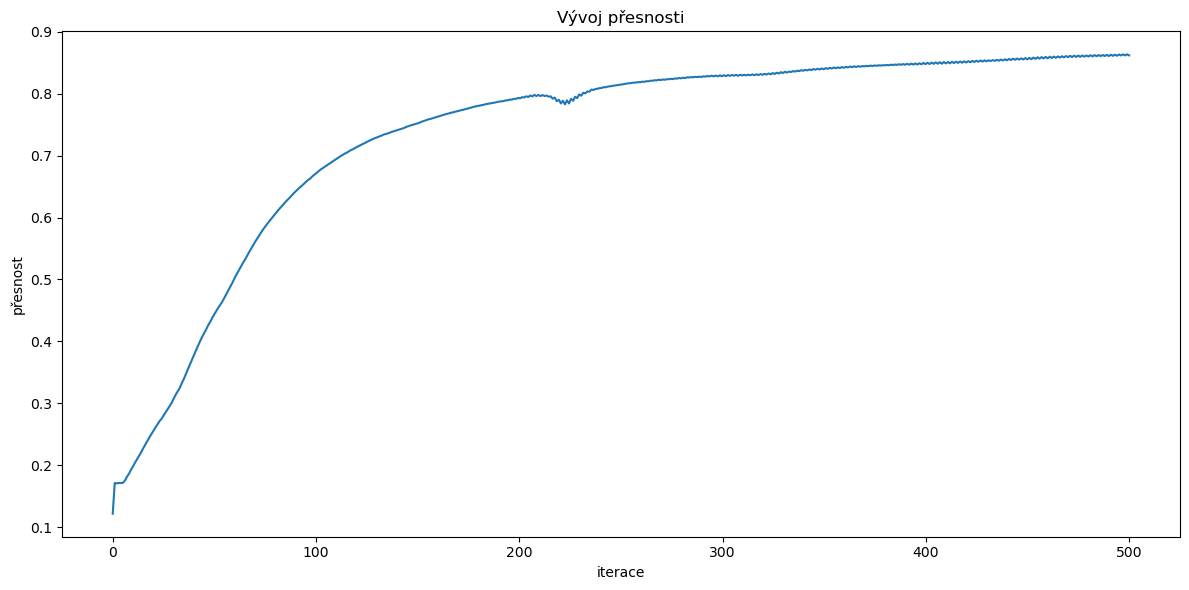

In [13]:
%matplotlib inline
pocet_presnosti = presnosti.size
osa_x = np.linspace(0, pocet_presnosti, pocet_presnosti)
plt.figure(figsize=(12,6))
plt.plot(osa_x, presnosti)
plt.xlabel('iterace')
plt.ylabel('přesnost')
plt.title('Vývoj přesnosti')
plt.tight_layout()

In [14]:
b2

array([[-0.11136547],
       [ 0.26155276],
       [-0.10826906],
       [ 0.65163682],
       [ 0.19542845],
       [ 0.12416529],
       [ 0.52869812],
       [ 0.5099068 ],
       [ 0.59296552],
       [-0.09103888],
       [ 0.11706286],
       [-0.28160858],
       [ 0.33817746],
       [-0.28168257],
       [ 0.46961734],
       [-0.30424569]])

In [15]:
def test_samostatne(index, W1, b1, W2, b2, W3, b3, X, Y):
    obrazek = X[:, index, None]
    _, _, _, _, _, A3 = dopredna_propagace(W1, b1, W2, b2, W3, b3, obrazek)
    odhad = odhady(A3)
    print('Odhad: ', odhad)
    print('Správné: ', Y[index])
    
    obrazek = obrazek.reshape(28,28) * 255
    plt.gray()
    plt.imshow(obrazek)
    plt.show()
    
def test(W1, b1, W2, b2, W3, b3, X, Y):
    _, _, _, _, _, A3 = dopredna_propagace(W1, b1, W2, b2, W3, b3, X)
    odhad = odhady(A3)
    presnost = zjisti_presnost(odhad, Y)
    return presnost

Odhad:  [4]
Správné:  4


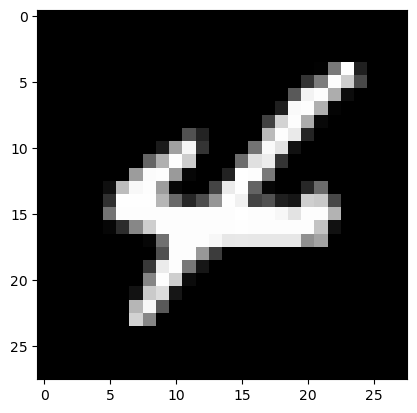

Odhad:  [4]
Správné:  4


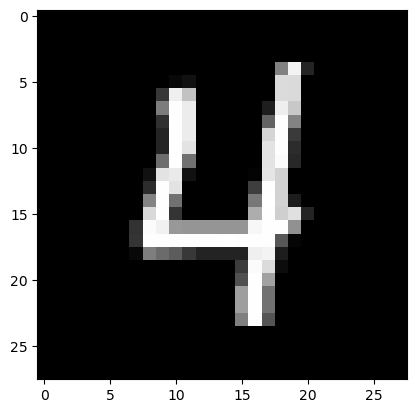

Odhad:  [9]
Správné:  9


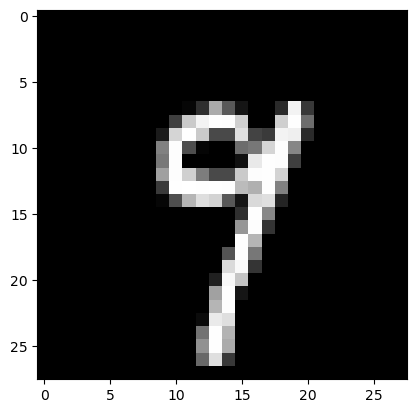

Odhad:  [0]
Správné:  0


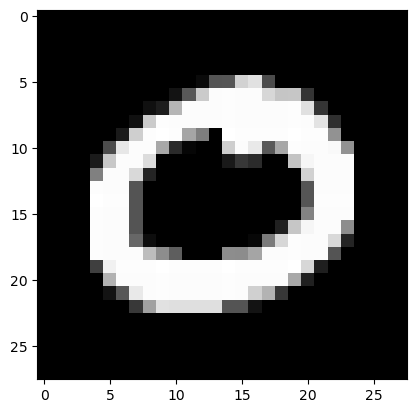

Odhad:  [3]
Správné:  3


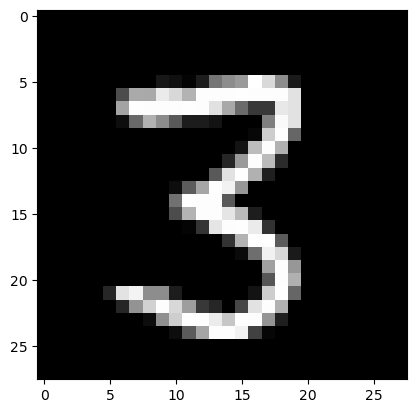

Odhad:  [6]
Správné:  6


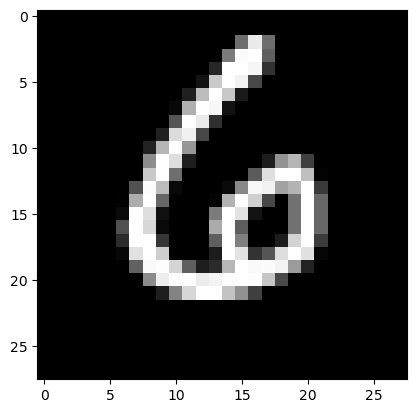

Odhad:  [0]
Správné:  0


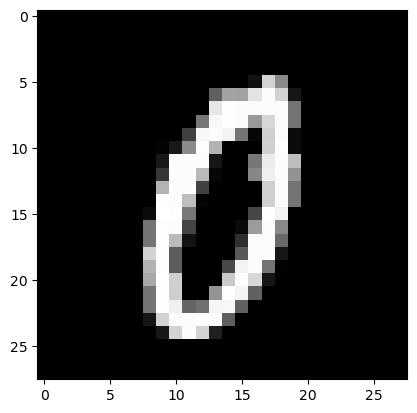

Odhad:  [8]
Správné:  8


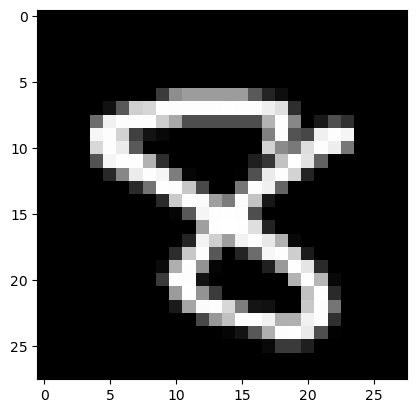

Odhad:  [5]
Správné:  0


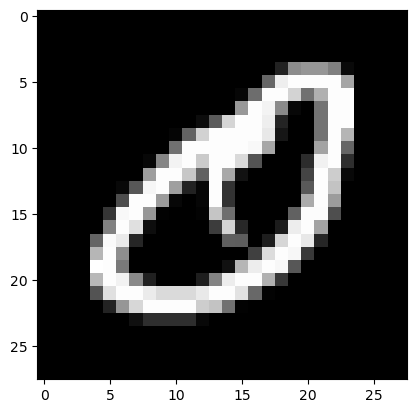

Odhad:  [0]
Správné:  0


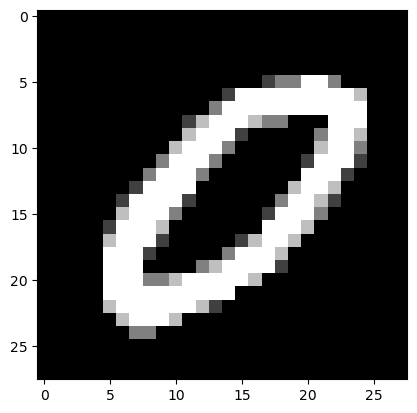

In [16]:
rozsah = 10
a = np.random.randint(0,Y_dev.size - rozsah)
for i in range(a, a + rozsah):
    test_samostatne(i, W1, b1, W2, b2, W3, b3, X_dev, Y_dev)

In [14]:
presnost = test(W1, b1, W2, b2, W3, b3, X_dev, Y_dev)
print('Přesnost: ', presnost * 100 ,  ' %')

NameError: name 'test' is not defined